
Iniciando RandomizedSearchCV para RandomForest...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Melhores parâmetros encontrados na RandomizedSearchCV (RF): {'class_weight': None, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 363}
Melhor acurácia média no CV (RandomizedSearchCV RF): 0.6937049317537987

Iniciando GridSearchCV para RandomForest com grid refinado...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Melhores parâmetros encontrados no GridSearchCV (RF): {'class_weight': None, 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 313}
Melhor acurácia média no CV (GridSearchCV RF): 0.6971027556013392

Iniciando RandomizedSearchCV para XGBoost...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Melhores parâmetros encontrados na RandomizedSearchCV (XGB): {'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 7, 

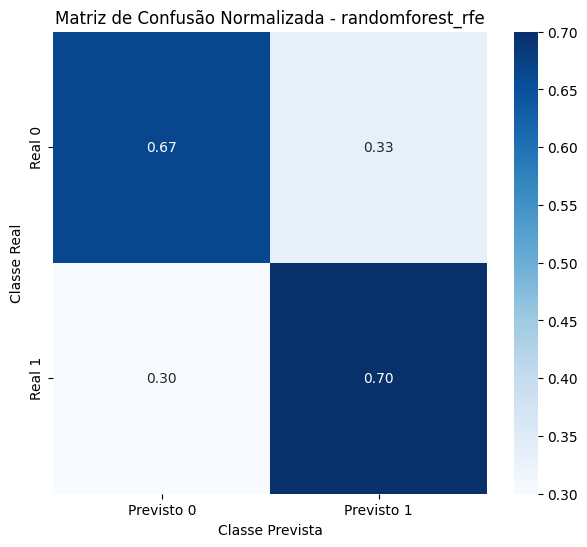

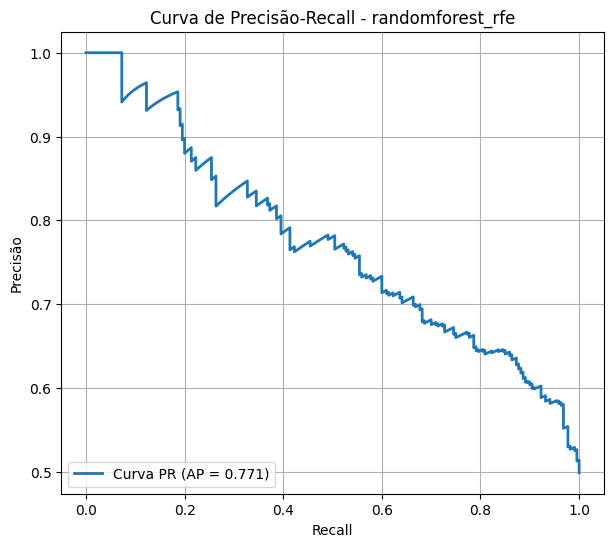

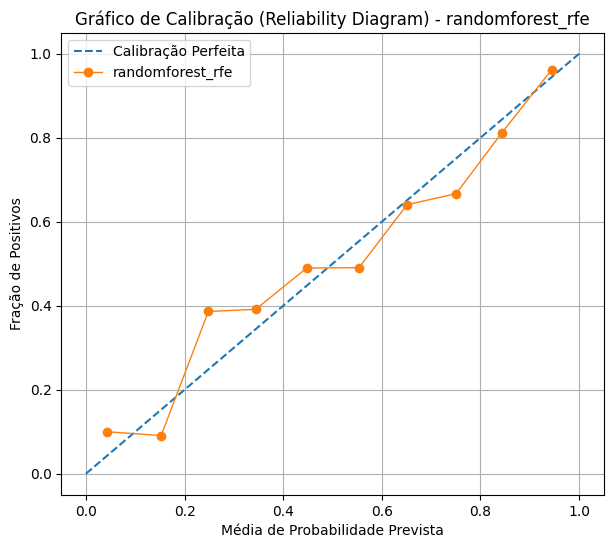

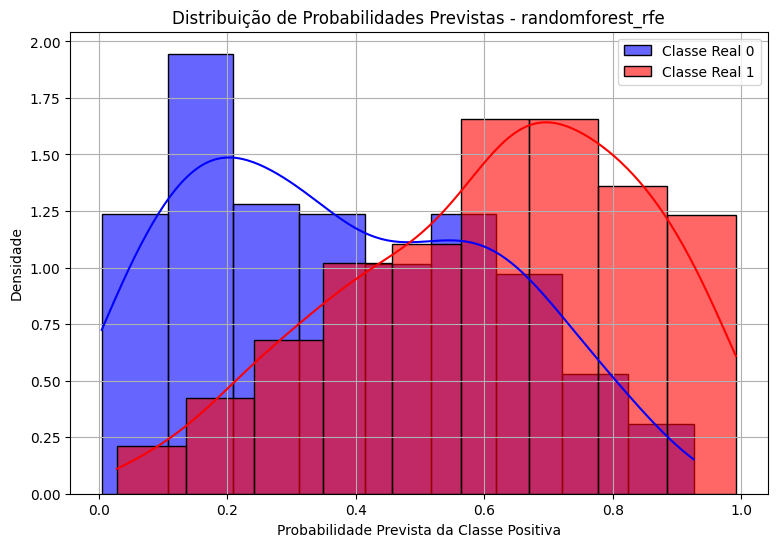

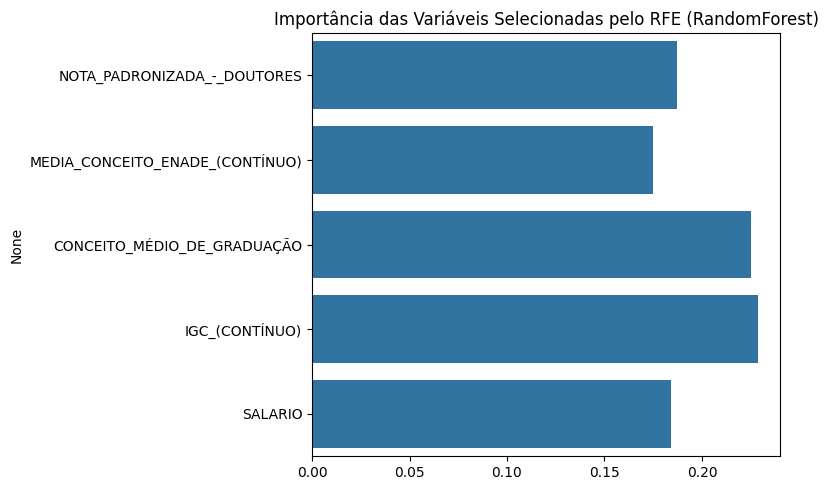


=== RFECV com RandomForest ===
Variáveis selecionadas pelo RFECV (RF): ['NOTA_PADRONIZADA_-_DOUTORES', 'MEDIA_CONCEITO_ENADE_(CONTÍNUO)', 'CONCEITO_MÉDIO_DE_GRADUAÇÃO', 'IGC_(CONTÍNUO)', 'SALARIO', 'QT_VG_TOTAL_MEDIA']

Modelo: randomforest_rfecv
Acurácia: 0.7007
Matriz de Confusão:
 [[151  70]
 [ 62 158]]
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.71      0.68      0.70       221
           1       0.69      0.72      0.71       220

    accuracy                           0.70       441
   macro avg       0.70      0.70      0.70       441
weighted avg       0.70      0.70      0.70       441



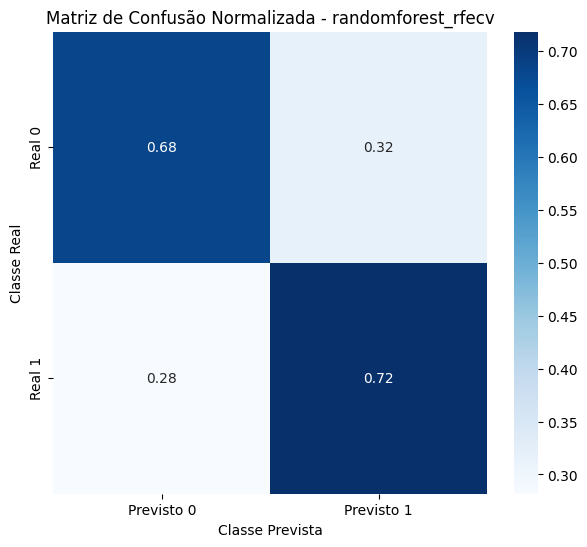

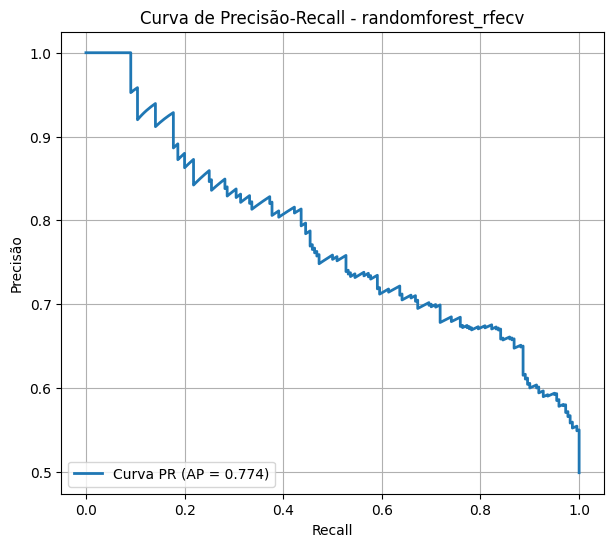

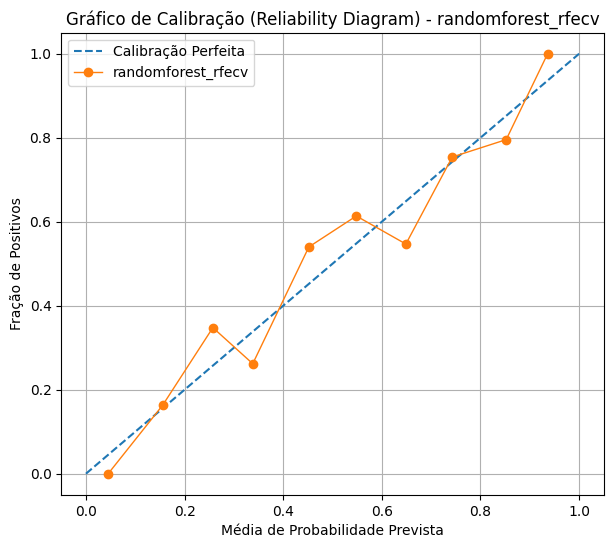

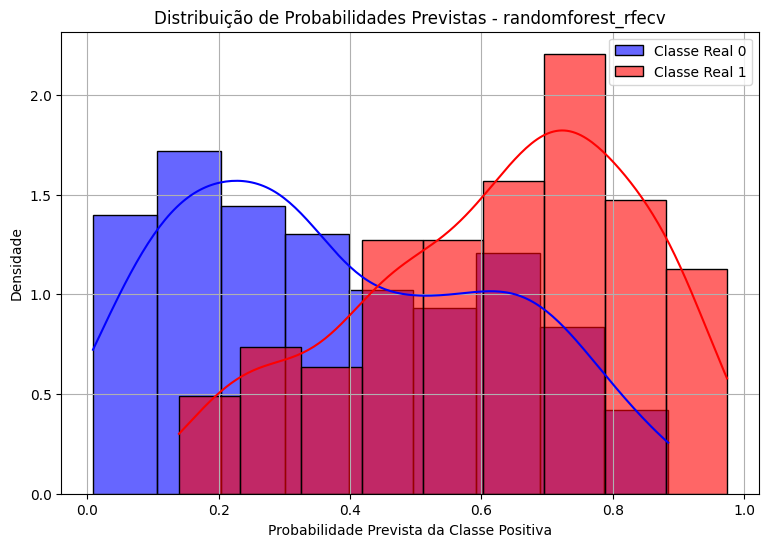

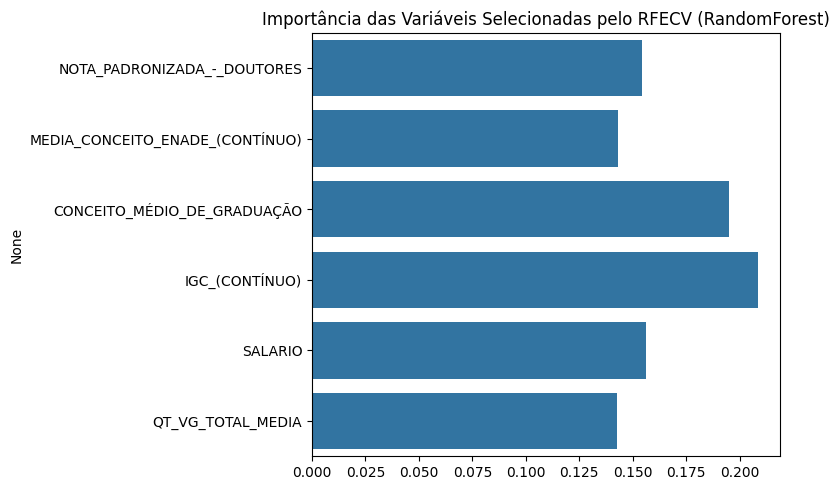


=== Avaliando modelos finais ===

Modelo: randomforest_final
Acurácia: 0.7166
Matriz de Confusão:
 [[154  67]
 [ 58 162]]
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.73      0.70      0.71       221
           1       0.71      0.74      0.72       220

    accuracy                           0.72       441
   macro avg       0.72      0.72      0.72       441
weighted avg       0.72      0.72      0.72       441



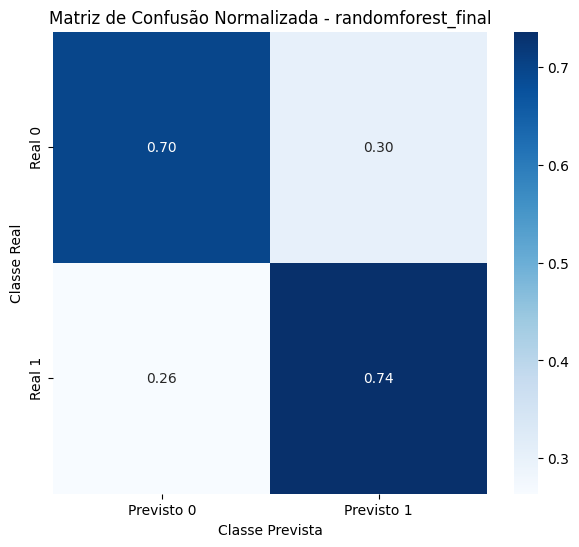

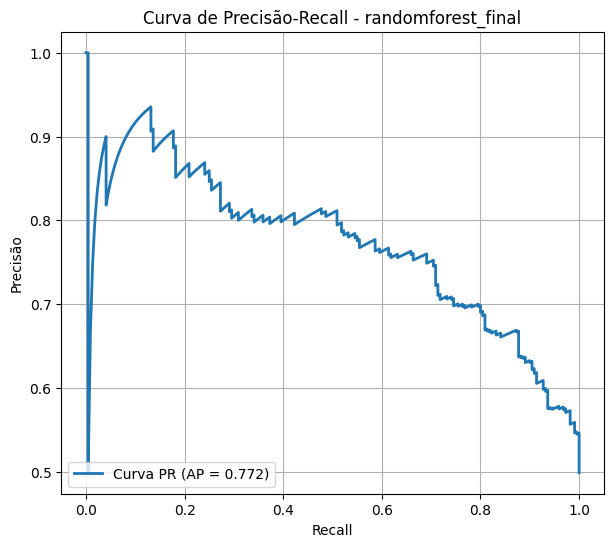

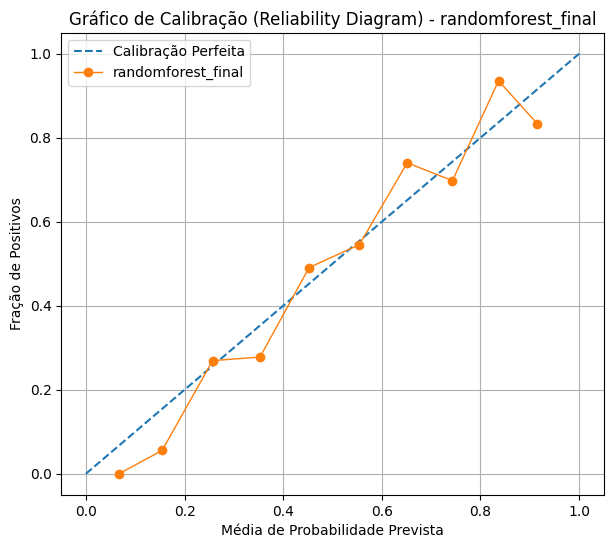

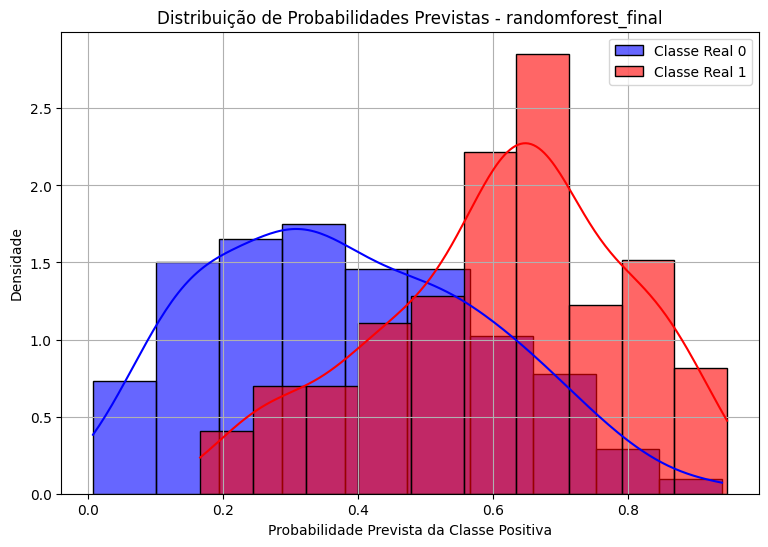


Modelo: xgboost_final
Acurácia: 0.7279
Matriz de Confusão:
 [[156  65]
 [ 55 165]]
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.74      0.71      0.72       221
           1       0.72      0.75      0.73       220

    accuracy                           0.73       441
   macro avg       0.73      0.73      0.73       441
weighted avg       0.73      0.73      0.73       441



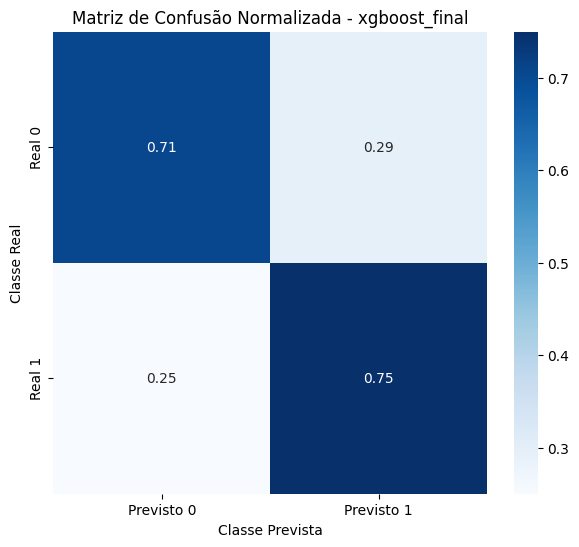

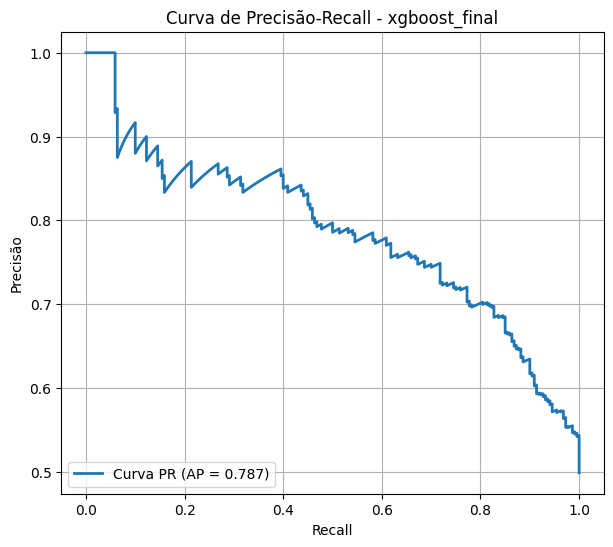

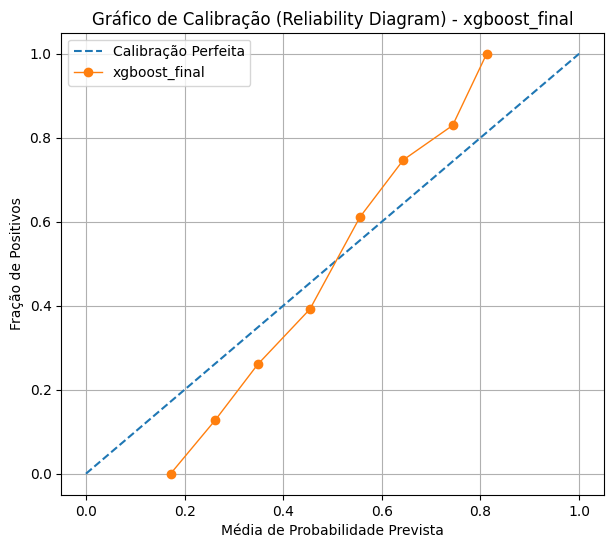

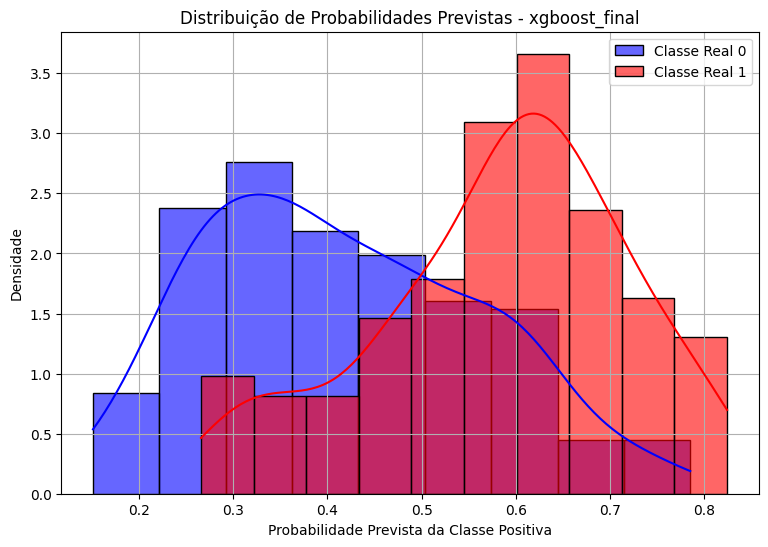

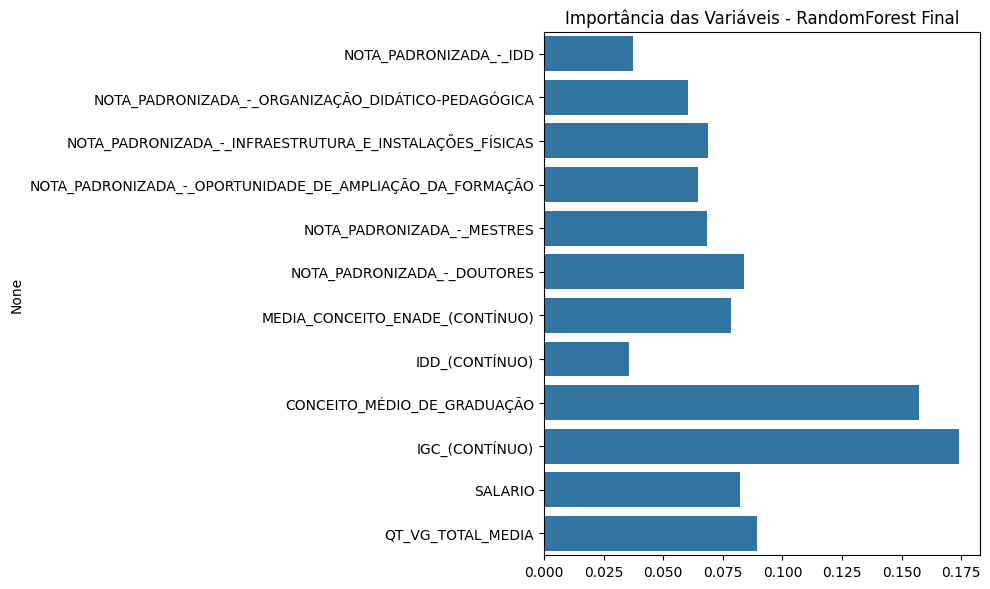

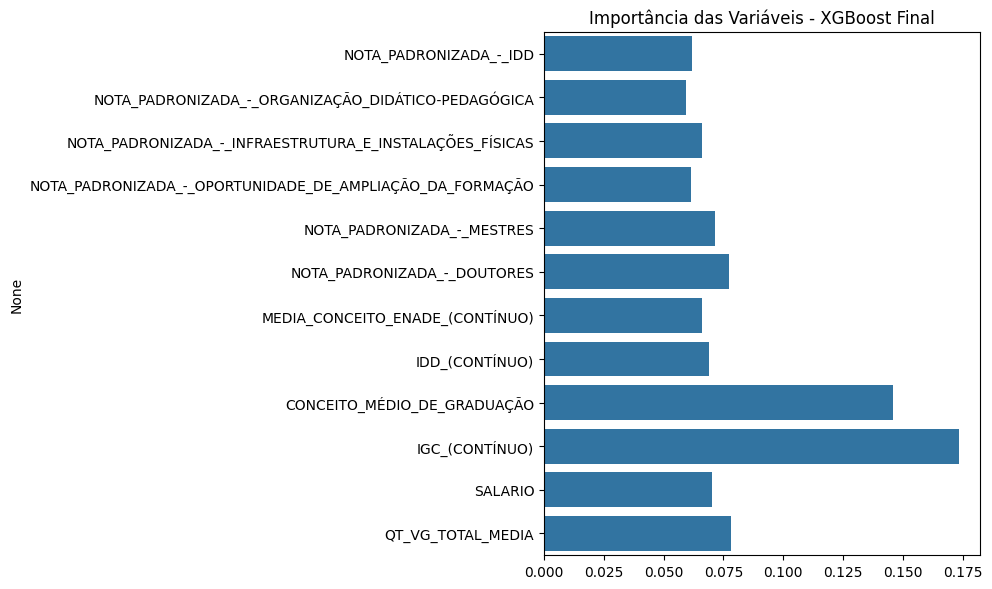

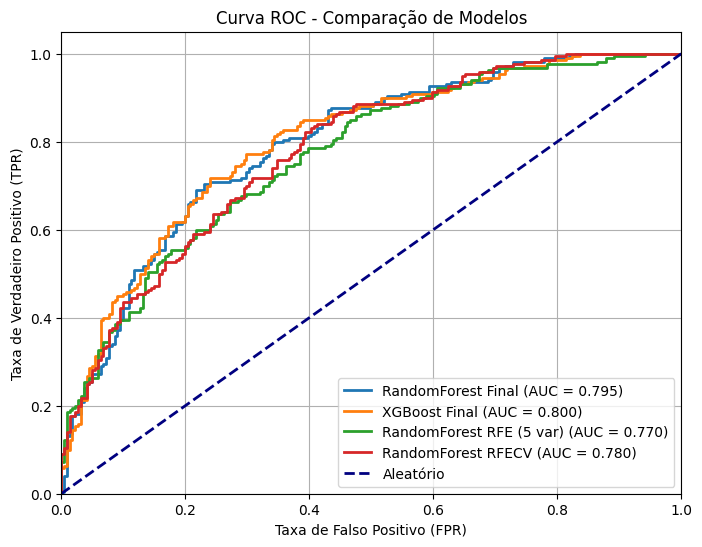

In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve
from scipy.stats import randint

import xgboost as xgb

# === 1. Carregar dados ===
df = pd.read_csv("../data/processed/ml_iq_2018_2023.csv")

variaveis_preditoras = [
    'NOTA_PADRONIZADA_-_IDD',
    'NOTA_PADRONIZADA_-_ORGANIZAÇÃO_DIDÁTICO-PEDAGÓGICA',
    'NOTA_PADRONIZADA_-_INFRAESTRUTURA_E_INSTALAÇÕES_FÍSICAS',
    'NOTA_PADRONIZADA_-_OPORTUNIDADE_DE_AMPLIAÇÃO_DA_FORMAÇÃO',
    'NOTA_PADRONIZADA_-_MESTRES',
    'NOTA_PADRONIZADA_-_DOUTORES',
    'MEDIA_CONCEITO_ENADE_(CONTÍNUO)',
    'IDD_(CONTÍNUO)',
    'CONCEITO_MÉDIO_DE_GRADUAÇÃO',
    'IGC_(CONTÍNUO)',
    'SALARIO',
    'QT_VG_TOTAL_MEDIA'
]

X = df[variaveis_preditoras]
y = df['TDA_binaria']

# === 2. Criar diretórios de saída ===
output_dir_viz = "../outputs/visualizations"
output_dir_reports = "../outputs/reports"
output_dir_models = "../outputs/models"
os.makedirs(output_dir_viz, exist_ok=True)
os.makedirs(output_dir_reports, exist_ok=True)
os.makedirs(output_dir_models, exist_ok=True)

# === 3. Dividir treino/teste ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)

# === 4. Função para avaliação e salvar resultados ===
def avaliar_modelo(modelo, X_treino, y_treino, X_teste, y_teste, nome_modelo):
    """
    Avalia um modelo de classificação, imprime métricas e gera diversos gráficos
    de avaliação.

    Args:
        modelo: O objeto modelo (já instanciado, mas não necessariamente treinado).
        X_treino (pd.DataFrame): Dados de treino.
        y_treino (pd.Series): Rótulos de treino.
        X_teste (pd.DataFrame): Dados de teste.
        y_teste (pd.Series): Rótulos de teste.
        nome_modelo (str): Nome do modelo para nomear os arquivos de saída.
    """
    modelo.fit(X_treino, y_treino)
    y_pred = modelo.predict(X_teste)

    # Obter probabilidades para métricas que as exigem
    if hasattr(modelo, "predict_proba"):
        y_prob = modelo.predict_proba(X_teste)[:, 1]
    else: # Para modelos que só têm decision_function (ex: SVC padrão)
        y_prob = modelo.decision_function(X_teste)
        # Normalizar para 0-1 se decision_function for usada e não estiver em escala de probabilidade
        y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())


    acc = accuracy_score(y_teste, y_pred)
    cm = confusion_matrix(y_teste, y_pred)
    cr = classification_report(y_teste, y_pred, output_dict=True)

    print(f"\nModelo: {nome_modelo}")
    print(f"Acurácia: {acc:.4f}")
    print("Matriz de Confusão:\n", cm)
    print("Relatório de Classificação:\n", classification_report(y_teste, y_pred))

    # Salvar relatório CSV
    df_report = pd.DataFrame(cr).transpose()
    df_report.to_csv(os.path.join(output_dir_reports, f"{nome_modelo}_classification_report.csv"))

    # Plot matriz de confusão normalizada heatmap
    plt.figure(figsize=(7, 6))
    # Normaliza a matriz de confusão pelas linhas (verdadeiros positivos/negativos em relação aos reais)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", cbar=True,
                xticklabels=['Previsto 0', 'Previsto 1'], yticklabels=['Real 0', 'Real 1'])
    plt.title(f"Matriz de Confusão Normalizada - {nome_modelo}")
    plt.xlabel("Classe Prevista")
    plt.ylabel("Classe Real")
    plt.savefig(os.path.join(output_dir_viz, f"{nome_modelo}_confusion_matrix_normalized.png"))
    plt.show()

    # Plot Curva de Precisão-Recall
    precision, recall, _ = precision_recall_curve(y_teste, y_prob)
    avg_precision = average_precision_score(y_teste, y_prob)
    plt.figure(figsize=(7, 6))
    plt.plot(recall, precision, lw=2, label=f'Curva PR (AP = {avg_precision:.3f})')
    plt.xlabel("Recall")
    plt.ylabel("Precisão")
    plt.title(f"Curva de Precisão-Recall - {nome_modelo}")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.savefig(os.path.join(output_dir_viz, f"{nome_modelo}_precision_recall_curve.png"))
    plt.show()

    # Plot Gráfico de Calibração (Reliability Diagram)
    fop, mpv = calibration_curve(y_teste, y_prob, n_bins=10, strategy='uniform')
    plt.figure(figsize=(7, 6))
    plt.plot([0, 1], [0, 1], linestyle='--', label='Calibração Perfeita')
    plt.plot(mpv, fop, marker='o', lw=1, label=nome_modelo)
    plt.xlabel("Média de Probabilidade Prevista")
    plt.ylabel("Fração de Positivos")
    plt.title(f"Gráfico de Calibração (Reliability Diagram) - {nome_modelo}")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.savefig(os.path.join(output_dir_viz, f"{nome_modelo}_calibration_plot.png"))
    plt.show()

    # Plot Distribuição de Probabilidades Previstas por Classe Real
    plt.figure(figsize=(9, 6))
    sns.histplot(y_prob[y_teste == 0], color='blue', label='Classe Real 0', kde=True, stat='density', alpha=0.6)
    sns.histplot(y_prob[y_teste == 1], color='red', label='Classe Real 1', kde=True, stat='density', alpha=0.6)
    plt.title(f"Distribuição de Probabilidades Previstas - {nome_modelo}")
    plt.xlabel("Probabilidade Prevista da Classe Positiva")
    plt.ylabel("Densidade")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir_viz, f"{nome_modelo}_probability_distribution.png"))
    plt.show()

    return {
        'accuracy': acc,
        'confusion_matrix': cm,
        'classification_report': cr,
        'y_pred': y_pred,
        'modelo': modelo
    }

# === 5. Ajustar lista para GridSearch refinado ===
def ajustar_lista_certas(val, passo=50, minimo=10):
    """
    Ajusta uma lista de valores para GridSearch refinado, criando uma pequena faixa
    ao redor do valor dado.
    """
    return sorted(list(set([
        max(minimo, val - passo),
        val,
        val + passo
    ])))

# === 6. RandomizedSearchCV para RandomForest ===
param_dist_rf = {
    'n_estimators': randint(100, 400),
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': randint(2, 6),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2', None],
    'class_weight': [None, 'balanced']
}

print("\nIniciando RandomizedSearchCV para RandomForest...")
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=30,
    cv=StratifiedKFold(5),
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search_rf.fit(X_train, y_train)

print("\nMelhores parâmetros encontrados na RandomizedSearchCV (RF):", random_search_rf.best_params_)
print("Melhor acurácia média no CV (RandomizedSearchCV RF):", random_search_rf.best_score_)

# Refinar GridSearch com melhores parâmetros RF
best_params_rf = random_search_rf.best_params_

param_grid_rf = {
    'n_estimators': ajustar_lista_certas(best_params_rf['n_estimators']),
    'max_depth': [best_params_rf['max_depth']] if best_params_rf['max_depth'] is not None else [None, 10, 20],
    'min_samples_split': ajustar_lista_certas(best_params_rf['min_samples_split'], passo=1, minimo=2),
    'min_samples_leaf': ajustar_lista_certas(best_params_rf['min_samples_leaf'], passo=1, minimo=1),
    'max_features': [best_params_rf['max_features']],
    'class_weight': [best_params_rf['class_weight']]
}

print("\nIniciando GridSearchCV para RandomForest com grid refinado...")
rf_grid = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_search_rf = GridSearchCV(
    estimator=rf_grid,
    param_grid=param_grid_rf,
    cv=StratifiedKFold(5),
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search_rf.fit(X_train, y_train)

print("\nMelhores parâmetros encontrados no GridSearchCV (RF):", grid_search_rf.best_params_)
print("Melhor acurácia média no CV (GridSearchCV RF):", grid_search_rf.best_score_)

melhor_rf = grid_search_rf.best_estimator_

# Salvar modelo RandomForest final
joblib.dump(melhor_rf, os.path.join(output_dir_models, "randomforest_final.pkl"))

# === 7. RandomizedSearchCV para XGBoost ===
param_dist_xgb = {
    'n_estimators': randint(100, 400),
    'max_depth': randint(3, 10),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_lambda': [1, 1.5, 2, 3]
}

print("\nIniciando RandomizedSearchCV para XGBoost...")
xgb_clf = xgb.XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1)

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist_xgb,
    n_iter=30,
    cv=StratifiedKFold(5),
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search_xgb.fit(X_train, y_train)

print("\nMelhores parâmetros encontrados na RandomizedSearchCV (XGB):", random_search_xgb.best_params_)
print("Melhor acurácia média no CV (RandomizedSearchCV XGB):", random_search_xgb.best_score_)

melhor_xgb = random_search_xgb.best_estimator_

# Salvar modelo XGBoost final
joblib.dump(melhor_xgb, os.path.join(output_dir_models, "xgboost_final.pkl"))

# === 8. Avaliação com RFE (5 variáveis) para RandomForest ===
print("\n=== RFE com RandomForest ===")
rfe = RFE(estimator=RandomForestClassifier(**best_params_rf, random_state=42, n_jobs=-1), n_features_to_select=5)
rfe.fit(X_train, y_train)
variaveis_rfe = X_train.columns[rfe.support_]
print(f"Variáveis selecionadas pelo RFE (RF): {list(variaveis_rfe)}")

res_rfe_rf = avaliar_modelo(rfe.estimator_, X_train[variaveis_rfe], y_train, X_test[variaveis_rfe], y_test, "randomforest_rfe")

plt.figure(figsize=(8,5))
sns.barplot(x=rfe.estimator_.feature_importances_, y=variaveis_rfe)
plt.title("Importância das Variáveis Selecionadas pelo RFE (RandomForest)")
plt.tight_layout()
plt.savefig(os.path.join(output_dir_viz, "randomforest_rfe_feature_importance.png"))
plt.show()

# === 9. Avaliação com RFECV para RandomForest ===
print("\n=== RFECV com RandomForest ===")
rfecv = RFECV(estimator=RandomForestClassifier(**best_params_rf, random_state=42, n_jobs=-1),
              step=1, cv=StratifiedKFold(5), scoring='accuracy', n_jobs=-1)
rfecv.fit(X_train, y_train)
variaveis_rfecv = X_train.columns[rfecv.support_]
print(f"Variáveis selecionadas pelo RFECV (RF): {list(variaveis_rfecv)}")

res_rfecv_rf = avaliar_modelo(rfecv.estimator_, X_train[variaveis_rfecv], y_train, X_test[variaveis_rfecv], y_test, "randomforest_rfecv")

plt.figure(figsize=(8,5))
sns.barplot(x=rfecv.estimator_.feature_importances_, y=variaveis_rfecv)
plt.title("Importância das Variáveis Selecionadas pelo RFECV (RandomForest)")
plt.tight_layout()
plt.savefig(os.path.join(output_dir_viz, "randomforest_rfecv_feature_importance.png"))
plt.show()

# === 10. Avaliação dos modelos finais ===
print("\n=== Avaliando modelos finais ===")
res_rf_final = avaliar_modelo(melhor_rf, X_train, y_train, X_test, y_test, "randomforest_final")
res_xgb_final = avaliar_modelo(melhor_xgb, X_train, y_train, X_test, y_test, "xgboost_final")

# --- Plot importância das variáveis do RandomForest final ---
plt.figure(figsize=(10,6))
importancias_rf = melhor_rf.feature_importances_
variaveis_rf = X_train.columns
sns.barplot(x=importancias_rf, y=variaveis_rf)
plt.title("Importância das Variáveis - RandomForest Final")
plt.tight_layout()
plt.savefig(os.path.join(output_dir_viz, "randomforest_final_feature_importance.png"))
plt.show()

# --- Plot importância das variáveis do XGBoost final ---
plt.figure(figsize=(10,6))
importancias_xgb = melhor_xgb.feature_importances_
variaveis_xgb = X_train.columns
sns.barplot(x=importancias_xgb, y=variaveis_xgb)
plt.title("Importância das Variáveis - XGBoost Final")
plt.tight_layout()
plt.savefig(os.path.join(output_dir_viz, "xgboost_final_feature_importance.png"))
plt.show()

# === 11. Plot ROC para comparação dos modelos ===

# Treinar RandomForest com variáveis selecionadas pelo RFE (com melhores parâmetros encontrados)
rf_rfe_model = RandomForestClassifier(**best_params_rf, random_state=42, n_jobs=-1)
rf_rfe_model.fit(X_train[variaveis_rfe], y_train)

# Treinar RandomForest com variáveis selecionadas pelo RFECV (com melhores parâmetros encontrados)
rf_rfecv_model = RandomForestClassifier(**best_params_rf, random_state=42, n_jobs=-1)
rf_rfecv_model.fit(X_train[variaveis_rfecv], y_train)

def plot_roc_curves(models, y_test, output_path=None):
    """
    Plota curvas ROC para múltiplos modelos para comparação.

    Args:
        models (dict): Dicionário onde a chave é o nome do modelo (str)
                       e o valor é uma tupla (objeto_modelo, X_teste_para_este_modelo).
        y_test (pd.Series): Rótulos reais do conjunto de teste.
        output_path (str, optional): Caminho para salvar a imagem. Defaults to None.
    """
    plt.figure(figsize=(8, 6))
    
    for nome_modelo, (modelo, X_teste) in models.items():
        # Verifica se o modelo possui predict_proba ou decision_function
        if hasattr(modelo, "predict_proba"):
            y_prob = modelo.predict_proba(X_teste)[:, 1]
        elif hasattr(modelo, "decision_function"):
            y_prob = modelo.decision_function(X_teste)
            # Normalizar para 0-1 se decision_function for usada e não estiver em escala de probabilidade
            y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())
        else:
            print(f"Modelo {nome_modelo} não possui predict_proba ou decision_function.")
            continue
        
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=2, label=f'{nome_modelo} (AUC = {roc_auc:.3f})')
    
    plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--', label='Aleatório')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falso Positivo (FPR)')
    plt.ylabel('Taxa de Verdadeiro Positivo (TPR)')
    plt.title('Curva ROC - Comparação de Modelos')
    plt.legend(loc='lower right')
    plt.grid(True)
    
    if output_path:
        plt.savefig(output_path)
    plt.show()

modelos_para_roc = {
    "RandomForest Final": (melhor_rf, X_test),
    "XGBoost Final": (melhor_xgb, X_test),
    "RandomForest RFE (5 var)": (rf_rfe_model, X_test[variaveis_rfe]),
    "RandomForest RFECV": (rf_rfecv_model, X_test[variaveis_rfecv])
}

plot_roc_curves(modelos_para_roc, y_test, output_path=os.path.join(output_dir_viz, "roc_comparacao_completo.png"))
